# Brain Games 3-classification using Neural Network

In [9]:
#check neurotech https://github.com/neurotech-berkeley
#check pyriemman https://github.com/alexandrebarachant
#definitely break down to waves and train them (P300, Alpha...)-->get relative power
#Plot power spetrum to see if there is noise in the higher frequencies
#Maybe Lasso Regression when we are getting zero-padded sparse fft data
#Focus != Difficulty
#Detect Relaxation (grow flowers, encourage relaxation)
#Real time stream automatic data preprocessing problem
#K-mean clustering fuzzy coefficients

In [40]:
%matplotlib inline
import numpy as np
import scipy.io
import sklearn
import scipy.cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy import signal
import time
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
import math
from sklearn.pipeline import make_pipeline
import mne
from mne.decoding import Vectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
#Try directly installing pyriemann in jupyter notebook if conda/pip doesn't make it
from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn
from collections import OrderedDict
import pandas as pd
import seaborn as sns




In [11]:
def loadData(sample_time, window_time, verbose, *args):
    csvData = []
    for a in args:
        csvData.append(np.genfromtxt(a, delimiter=','))
    min_len = min([c.shape[0] for c in csvData])
    if verbose: print("There are {l} raw data points".format(l=min_len))
    csvData = [c[:min_len,:] for c in csvData]
    sample_len = csvData[0].shape[0] - 1
    window_num = (int)(sample_time//window_time) 
    data_per_window = (int)(sample_len//(window_num)) #data_per_window = datapoints per window = sample_len // (window_num)
    #assert(data_per_window % 2 == 0)

    if verbose: print("There are",data_per_window, "datapoints per window, and there are", window_num, "independent windows.")
    channel = []
    for d in csvData:
        channel.append(d[1:,1:])
        """print(d.shape)
        plt.plot(d[2000:-1000,2:3])
        plt.xlim((0,d.shape[0]))
        plt.title('A Very Representative Feature VS Full Time')
        plt.figure(figsize = (16,9))"""
    #print(np.asarray(channel).shape)
    #trimData(sample_len, data_per_window, channel)
    return sample_len, data_per_window, channel

In [12]:
def trimData(sample_len, data_per_window, channel, verbose):
    residual = sample_len % data_per_window
    if verbose: print("There are", residual, "points left out by segmentation, now cutting them from both ends...")
    residualStart = residual // 2
    residualEnd = residual - residualStart
    residualEnd = len(channel[0]) - residualEnd
    #print(len(channel[0]), residualStart, residualEnd)

    pruned = []
    for c in channel:
        pruned.append(c[residualStart : residualEnd,:])
    pruned = np.asarray(pruned)
    if verbose: print("The shape of the pruned dataset is: ", pruned.shape)
    if verbose: print("The first number stands for the number of classes, the second number stands for raw data points and the third number stands for the number of channels")
    for p in pruned:
        assert np.asarray(p).shape[0] % data_per_window == 0, np.asarray(p).shape[0] % data_per_window
    return pruned

In [13]:
def find_fft_len(data_per_window):
    result = 2**math.ceil(math.log2(data_per_window))
    return result, data_per_window/result

def stft_for_one_channel(nfft, data_per_window, data):
    #nfft should be the closest power of 2 to data_per_window
    f,t,Zxx = scipy.signal.stft(data, nperseg=data_per_window, return_onesided=False, padded=True, nfft=nfft)
    #assert (Zxx.shape[1] == 2*window_num*len(csvData) + 1)
    #print("There are", Zxx.shape[1],"time window captured by STFT...")
    Zxx = Zxx.T #Zxx = new data matrix --> time windows are our new data points and frequency are the features
    #We sacrificed segements of data to expand feature size from 1 to 256
    #print(Zxx.shape)
    #print("Parsing each DFT to extract the actual coefficients used in the trucated Fourier Series...")
    for i in range(0,Zxx.shape[0]):
        chnl = Zxx[i]
        chnl[0] = chnl[0].real
        chnl[1:nfft//2] = 1*chnl[1:nfft//2].real
        chnl[nfft//2] = chnl[nfft//2]
        chnl[nfft//2 + 1:] = (1)*chnl[nfft//2 + 1:].imag
    assert ((Zxx.real == Zxx).all())
    #print("Coefficient extracted!")
    Zxx = Zxx.real #The imaginary compoenent is 0 by now, we are just getting rid of the j for PCA
    #Since PCA from sklearn doesn't handle complex data, let us simply use the weight of thecosine part of the frequency space
    return Zxx


def stft(data_per_window, pruned, verbose):
    nfft, percentage = find_fft_len(data_per_window) #depending on the window size
    if verbose: print("FFT length: ", nfft)
    #We again reduce the data size and increase the features from 5 to 5*nfft
    post_stft_dataset = []
    if verbose: print("Parsing each DFT to extract the actual coefficients used in the trucated Fourier Series...")
    for p in pruned:
        expanded_features_dataset = []
        for i in range(p.shape[1]):
            channel = p[:,i]
            stft_results = stft_for_one_channel(nfft, data_per_window, channel)
            expanded_features_dataset.append(stft_results)
        expanded_features_dataset = np.asarray(expanded_features_dataset)
        #We will hstack the the stfted results for each channel for this particular class
        hstacked = expanded_features_dataset[0]
        for expanded_channel in expanded_features_dataset[1:]:
            hstacked = np.hstack((hstacked, expanded_channel))
        post_stft_dataset.append(hstacked)
    if verbose: print("Coefficient extracted!")
    post_stft_dataset = np.asarray(post_stft_dataset)
    if verbose: print("The transformed dataset after STFT: ", post_stft_dataset.shape)
    if verbose: print("The first number stands for the number of classes, the second number stands for new data points and the third number stands for the number of features")
    return post_stft_dataset, nfft, percentage

In [14]:
def three_d_train_test_split(three_d_dataset, label, ratio):
    #Outputs 3d matrices for train and test set
    split = (int)(three_d_dataset.shape[0] * ratio)
    y = label * np.ones(three_d_dataset.shape[0])
    return three_d_dataset[:split], three_d_dataset[split:], y[:split], y[split:]

def conglomerates(three_d_matrix):
    #Outputs 2d matrices, stacked along the first axis
    vstacked = three_d_matrix[0]
    for m in three_d_matrix[1:]:
        vstacked = np.vstack((vstacked, m))
    return vstacked

In [15]:
def make_train_test(post_stft_dataset, ratio):
    X_train, X_test, y_train, y_test = [],[],[],[]
    for i in range(post_stft_dataset.shape[0]):
        xtr, xt, ytr, yt = three_d_train_test_split(post_stft_dataset[i],i,0.8)
        X_train.append(xtr)
        X_test.append(xt)
        y_train.append(ytr)
        y_test.append(yt)
    X_train = conglomerates(np.asarray(X_train))
    X_test = conglomerates(np.asarray(X_test))
    y_train = np.asarray(y_train).flatten()
    y_test = np.asarray(y_test).flatten()
    
    assert X_train.shape[0] == y_train.shape[0]
    assert X_test.shape[0] == y_test.shape[0]
    
    return X_train, y_train, X_test, y_test

In [16]:
def train(max_iter, alpha, solver, X_train, y_train, X_test, y_test):
    #adam, lbfgs, sgd
    #alhpa: 1e-8
    mlp = MLPClassifier(hidden_layer_sizes=(200,20), max_iter=max_iter, alpha=alpha,
                    solver=solver, verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)
    mlp.fit(X_train, y_train)
    train_scr = mlp.score(X_train, y_train)
    test_scr = mlp.score(X_test, y_test)
    print("Training set score: %f" % train_scr)
    print("Test set score: %f" % test_scr)
    return train_scr, test_scr

0.5
The average AUC score is: [0.6197278911564625, 0.5650085034013606, 0.5650085034013606, 0.7917091836734693, 0.6893707482993197]


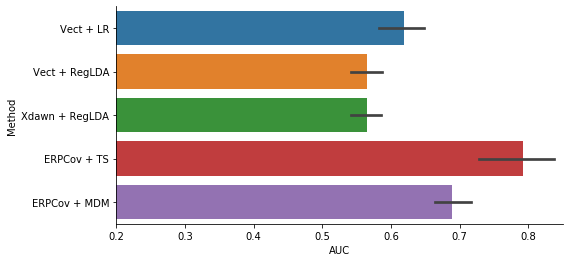

In [59]:
def run(window_len, verbose):
    print(window_len)
    if verbose: print("Loading Data...")
    sample_len, data_per_window, channel = loadData(60, window_len, verbose, "60sactualrest.csv", "60smultiplication5.4lvl.csv")
    if verbose: print("===================================================================================")
    if verbose: print("")
    if verbose: print("Triming Data...")
    pruned = trimData(sample_len, data_per_window, channel, verbose)
    if verbose: print("===================================================================================")
    if verbose: print("")
    if verbose: print("STFTing Data...")
    post_stft_dataset, nfft, percentage = stft(data_per_window, pruned, verbose)
    if verbose: print("Data Transformed!")
    if verbose: print("===================================================================================")
    if verbose: print("")
    if verbose: print("Training Data...")
    #print((data_per_window/nfft)*100,"%")
    X_train, y_train, X_test, y_test = make_train_test(post_stft_dataset, 0.8)
    train_scr, test_scr = train(100, 1e-8, 'lbfgs', X_train, y_train, X_test, y_test)
    return train_scr, test_scr, percentage
def run_neurotech(window_len, verbose):
    clfs = OrderedDict()

    clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
    clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
    clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
    clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
    clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())
    # format data
    print(window_len)
    if verbose: print("Loading Data...")
    sample_len, data_per_window, channel = loadData(60, window_len, verbose, "60sactualrest.csv", "60smultiplication5.4lvl.csv")
    if verbose: print("===================================================================================")
    if verbose: print("")
    if verbose: print("Triming Data...")
    pruned = trimData(sample_len, data_per_window, channel, verbose)
    if verbose: print("===================================================================================")
    if verbose: print("")
    if verbose: print("STFTing Data...")
    post_stft_dataset, nfft, percentage = stft(data_per_window, pruned, verbose)
    if verbose: print("Data Transformed!")
    if verbose: print("===================================================================================")
    if verbose: print("")
    if verbose: print("Training Data...")
    
    X_train, y_train, X_test, y_test = make_train_test(post_stft_dataset, 0.8)
    X = np.vstack((X_train,X_test))
    X = np.reshape(X, newshape=(X.shape[0],1,X.shape[1]))
    y = np.vstack((np.reshape(y_train,newshape=(y_train.shape[0],1)),np.reshape(np.asarray(y_test), newshape=(y_test.shape[0],1))))
    y = y.flatten() #crucial, sklearn prefers a vector not an array for labels
    assert X.shape[0] == y.shape[0]
    # define cross validation 
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

    # run cross validation for each pipeline
    auc = []
    mean = []
    methods = []
    for m in clfs:
        res = cross_val_score(clfs[m], X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
        mean.append(np.mean(res))
        auc.extend(res)
        methods.extend([m]*len(res))

    results = pd.DataFrame(data=auc, columns=['AUC'])
    results['Method'] = methods
    print("The average AUC score is:",mean)

    plt.figure(figsize=[8,4])
    sns.barplot(data=results, x='AUC', y='Method')
    plt.xlim(0.2, 0.85)
    sns.despine()

    
win_len_list = [0.5*i for i in range(1, 2)]
test_res = []
train_res = []
percent_res = []
for w in win_len_list:   
    #train_scr, test_scr, percent_scr = run_neurotech(w, False)
    run_neurotech(w, False)
    #train_res.append(train_scr)
    #test_res.append(test_scr)
    #percent_res.append(percent_scr)

#plt.plot(win_len_list, train_res, label = "Train Score")
#plt.plot(win_len_list, test_res, label = "Test Score")
#plt.plot(win_len_list, percent_res, label = "Percentage Score")
#plt.xlabel("Window Length (s)")
#plt.ylabel("Score")
#plt.title("Score VS Window Length")
#plt.legend()
    

In [27]:
print(np.mean(test_res))
print(np.mean(train_res))
#SGD Mean: Test 0.4848184223184223, Train 0.5188464252400026
#LBFGS 1MIN Mean: Test 0.6651543651414771, Train 0.9402328392207571
#LBFGS 1MIN Mean Standarized: Test 0.4944845437674585, Train 1.0 seems like normalization makes it worse
#LBFGS 10MIN Mean: Test: 0.6221004202855277, Train 0.7853136992342494
#ADAM Mean: Test 0.5002369225627413, Train 0.9166582700882311

0.652958998779444
0.9353047934479269


In [ ]:
X_pca = conglomerates(post_stft_dataset)
print(X_pca.shape)

#try neural network on PCAed data
pc_num = 10

print("Doing PCA analysis ...")
start_time = time.time()
pca = PCA(n_components = pc_num)
pca.fit(X_pca)
mean = pca.mean_
pc = pca.components_[:pc_num]
end_time = time.time()
print("Done!")
print("Duration: ", end_time - start_time)

In [ ]:
def PCA_project(data, new_basis, mean):
    #To see the data's repr in the basis of principal components
    return np.dot((data-mean), new_basis.T)
def deconglomerates(post_pca_two_d_matrix):
    three_d = []
    divider = (int)(post_pca_two_d_matrix.shape[0]/post_stft_dataset.shape[0])
    assert post_pca_two_d_matrix.shape[0]%post_stft_dataset.shape[0] == 0
    three_d = [post_pca_two_d_matrix[i*divider:(i+1)*divider] for i in range(0,post_stft_dataset.shape[0])]
    return np.asarray(three_d)



In [ ]:
plt.figure(figsize = (16,9))
proj = PCA_project(X_pca, pc, mean)
print(proj.shape)
PCA_projected_dataset = deconglomerates(proj)
print(PCA_projected_dataset.shape)
assert PCA_projected_dataset.shape[0] == post_stft_dataset.shape[0]
assert PCA_projected_dataset.shape[1] == post_stft_dataset.shape[1]

In [59]:
Xp_train, Xp_test, yp_train, yp_test = [],[],[],[]
for i in range(PCA_projected_dataset.shape[0]):
    xtr, xt, ytr, yt = three_d_train_test_split(PCA_projected_dataset[i],i,0.8)
    Xp_train.append(xtr)
    Xp_test.append(xt)
    yp_train.append(ytr)
    yp_test.append(yt)
Xp_train = conglomerates(np.asarray(Xp_train))
Xp_test = conglomerates(np.asarray(Xp_test))
yp_train = np.asarray(yp_train).flatten()
yp_test = np.asarray(yp_test).flatten()

assert Xp_train.shape[0] == yp_train.shape[0]
assert Xp_test.shape[0] == yp_test.shape[0]

In [60]:
mlp = MLPClassifier(hidden_layer_sizes=(200,20), max_iter=50, alpha=1e-6,
                    solver='adam', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

In [61]:
mlp.fit(Xp_train, yp_train)
print("Training set score: %f" % mlp.score(Xp_train, yp_train))
print("Test set score: %f" % mlp.score(Xp_test, yp_test))

Iteration 1, loss = inf
Iteration 2, loss = 1.23988586
Iteration 3, loss = 1.10148277
Iteration 4, loss = 1.10038323
Iteration 5, loss = 1.10293012
Iteration 6, loss = 1.10282839
Iteration 7, loss = 1.10049364
Iteration 8, loss = 1.10022342
Iteration 9, loss = 1.09981903
Iteration 10, loss = 1.10235450
Iteration 11, loss = 1.09932167
Iteration 12, loss = 1.09948772
Iteration 13, loss = 1.10111882
Iteration 14, loss = 1.10548646
Iteration 15, loss = 1.10011708
Iteration 16, loss = 1.10012716
Iteration 17, loss = 1.10559643
Iteration 18, loss = 1.10305810
Iteration 19, loss = 1.10029459
Iteration 20, loss = 1.10415273
Iteration 21, loss = 1.10057255
Iteration 22, loss = 1.10705179
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training set score: 0.333333
Test set score: 0.333333
